Predicting Newsletter Subscriptions Using Player Engagement Data

I. Introduction

Background: Free video games, similar to Minecraft, often employ various methods, such as in-game purchases, ads, and newsletter subscriptions, to generate revenue and maintain player interest. Understanding what motivates players to subscribe to newsletters enables developers to target their marketing more effectively and enhance player retention. Session frequency and length are commonly used to predict whether a player will subscribe to a newsletter.

Research Question:
    Can the frequency of a player's gaming sessions and their average session duration predict whether they will subscribe to a game's newsletter?

Data Description:
    This study uses two main datasets:

Player Demographics (players-2.csv):
- hashedEmail: Unique anonymized identifier for each player.
- subscribe: Indicates if a player subscribed to the newsletter (Yes/No).
- gender: Player’s gender (male, female, other).
- experience: Self-reported level of gaming experience (newbie, intermediate, veteran).

Session Logs (sessions-2.csv):
- hashedEmail: Identifiers linking each session to the demographic data.
- start_time / end_time: Session timestamps recorded in UTC (day/month/year hour:minute), used to calculate the duration of each session in minutes.

After merging and cleaning these datasets, each player's data is summarized into several key metrics: the total number of sessions, average session duration, and total playtime. These summary metrics will then be used to build and test a k-nearest neighbors (k-NN) classification model to predict the likelihood of newsletter subscription.

II. Method and results 
Description:

In [31]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2) 

In [32]:
#Load datasets
players <- read_csv("Data/players-2.csv")
sessions <- read_csv("Data/sessions-2.csv")
head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [47]:
#Wrangle and clean data
session_info_clean <- sessions |>
  mutate(start_time = dmy_hm(start_time, tz = "UTC"),
    end_time = dmy_hm(end_time, tz = "UTC"),
    session_length = as.numeric(difftime(end_time, start_time, units = "mins"))) 

session_summary <- session_info_clean |>
  group_by(hashedEmail) |>
  summarise(total_sessions = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_playtime_mins = sum(session_length, na.rm = TRUE),
    .groups = "drop")

merged_df <- players |> #Merged datasets on the hashedEmail identifier.
  mutate(subscribe = factor(subscribe))|>
  left_join(session_summary, by = "hashedEmail") |>
  drop_na(subscribe, total_sessions, avg_session_length)

#Exploratory Data Analysis
overall_summary <- merged_df|>
summarise(
    mean_sessions   = mean(total_sessions),
    med_sessions    = median(total_sessions),
    mean_length     = mean(avg_session_length),
    med_length      = median(avg_session_length),
    pct_subscribed  = mean(as.integer(subscribe) == max(as.integer(subscribe))))

subcribe_counts <- merged_df |>
  count(subscribe) |>
  mutate(pct = n / sum(n))

df_knn <- merged_df |>
  select(total_sessions, avg_session_length, subscribe)

head(df_knn)
overall_summary
subcribe_counts

total_sessions,avg_session_length,subscribe
<int>,<dbl>,<fct>
27,74.77778,TRUE
3,85.00000,TRUE
1,5.00000,FALSE
1,50.00000,TRUE
1,9.00000,TRUE
1,5.00000,FALSE


mean_sessions,med_sessions,mean_length,med_length,pct_subscribed
<dbl>,<int>,<dbl>,<dbl>,<dbl>
12.28,1,32.51137,18.5,0.744


subscribe,n,pct
<fct>,<int>,<dbl>
FALSE,32,0.256
TRUE,93,0.744


Generated summary statistics indicated an average of 12.28 sessions per player, though the median was only 1, suggesting a skewed distribution. The average session length was 32.51 minutes, with a median of 18.5 minutes, indicating skewness due to the influence of some longer sessions on the mean. Additionally, approximately 74.4% of players subscribed to the newsletter.

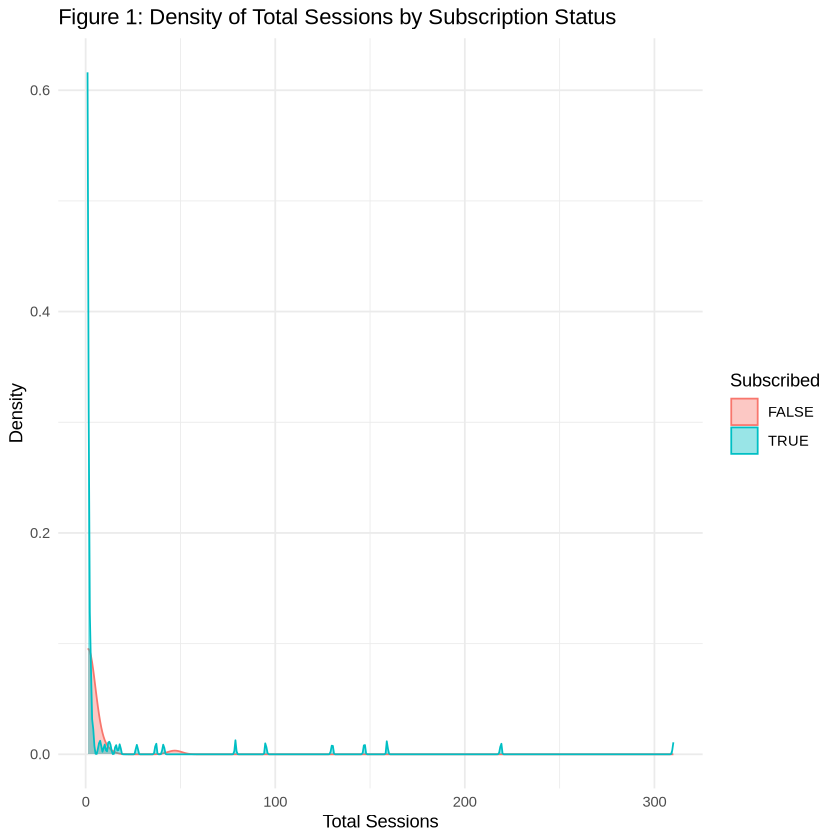

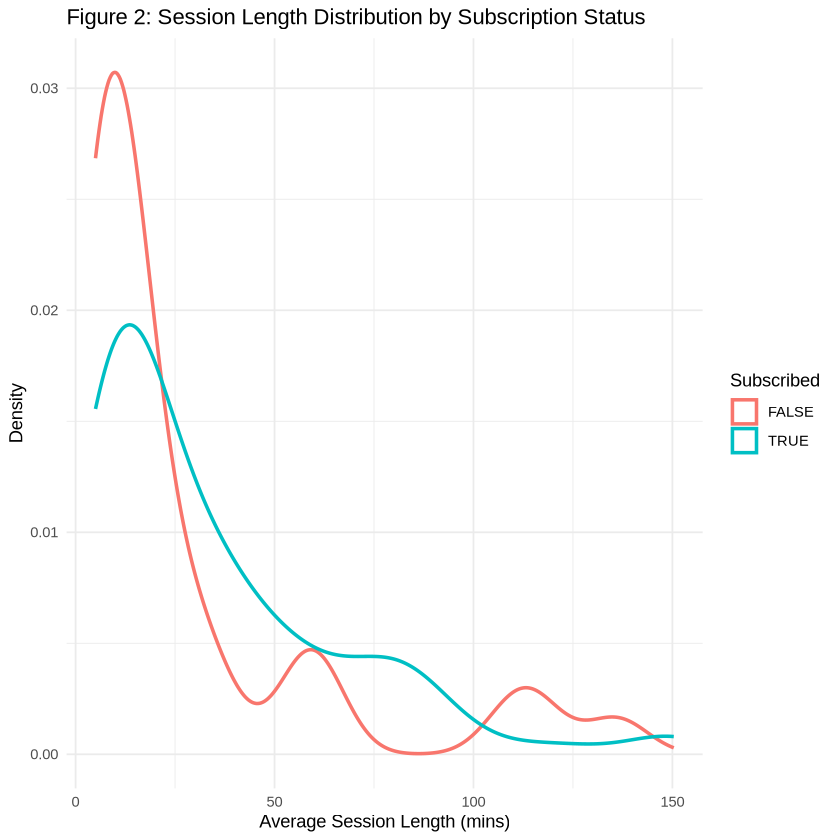

In [43]:
# Exploratory Visualizations
figure1 <- ggplot(merged_df, aes(x = total_sessions, color = subscribe, fill = subscribe)) +
  geom_density(alpha = 0.4) +
  labs(title = "Figure 1: Density of Total Sessions by Subscription Status",
    x = "Total Sessions",
    y = "Density",
    color = "Subscribed",
    fill = "Subscribed") +
  theme_minimal()

figure2 <- ggplot(merged_df, aes(x = avg_session_length, color = subscribe)) +
  geom_density(linewidth = 1) +
  labs(
    title = "Figure 2: Session Length Distribution by Subscription Status",
    x     = "Average Session Length (mins)",
    y     = "Density",
    color = "Subscribed") +
  theme_minimal()

figure1
figure2 

Figure 1 shows that subscribers tend to have more total sessions than non-subscribers, indicating higher play frequency. Figure 2 shows that subscribers also tend to have longer session lengths. Together, these patterns suggest that players who play more often and for longer are more likely to subscribe, supporting the idea that engagement is a strong predictor of subscription.

neighbors,.config
<dbl>,<chr>
11,Preprocessor1_Model06


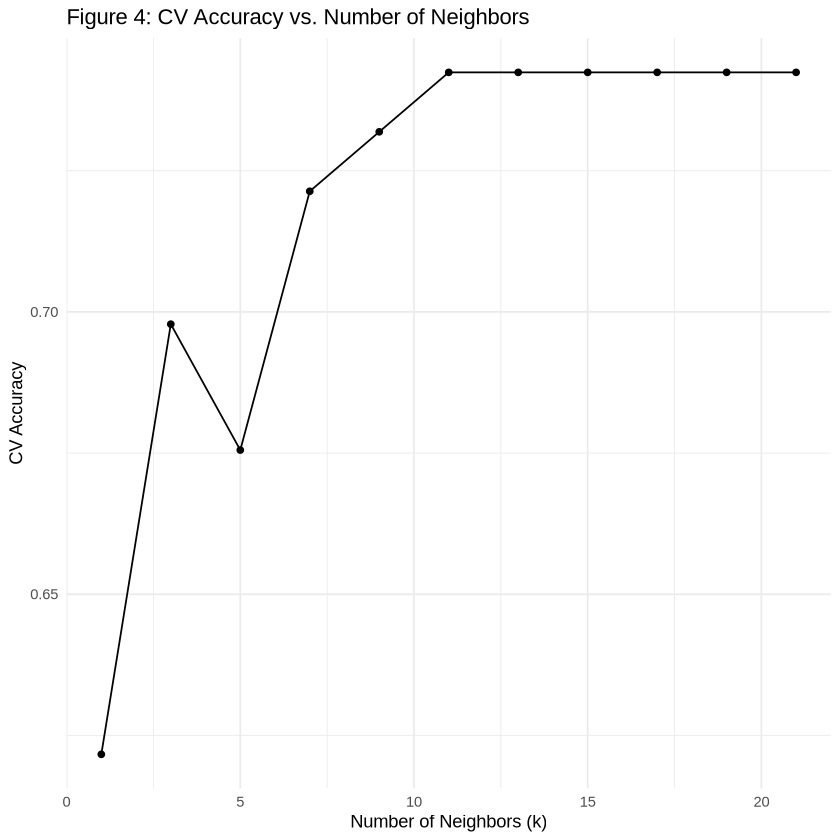

In [48]:
#Data summary
set.seed(123)
data_split <- initial_split(df_knn, prop = 0.75, strata = subscribe)
train_data  <- training(data_split)
test_data   <- testing(data_split)

knn_recipe <- recipe(subscribe ~ total_sessions + avg_session_length, data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_tune_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_tune_wf <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune_spec)

knn_grid <- tibble(neighbors = seq(1, 21, by = 2))

tune_results <- knn_tune_wf |>
  tune_grid(resamples = cv_folds,grid = knn_grid)

best_k <- tune_results |>
  select_best("accuracy")
best_k

figure4 <- tune_results |> 
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  ggplot(aes(neighbors, mean)) +
    geom_line() +
    geom_point() +
    labs(title = "Figure 4: CV Accuracy vs. Number of Neighbors",
      x = "Number of Neighbors (k)",
      y = "CV Accuracy") +
    theme_minimal()
figure4

# A tibble: 2 × 4
  .metric  .estimator .estimate .config             
  <chr>    <chr>          <dbl> <chr>               
1 accuracy binary         0.719 Preprocessor1_Model1
2 roc_auc  binary         0.599 Preprocessor1_Model1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71875


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9583333


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7419355


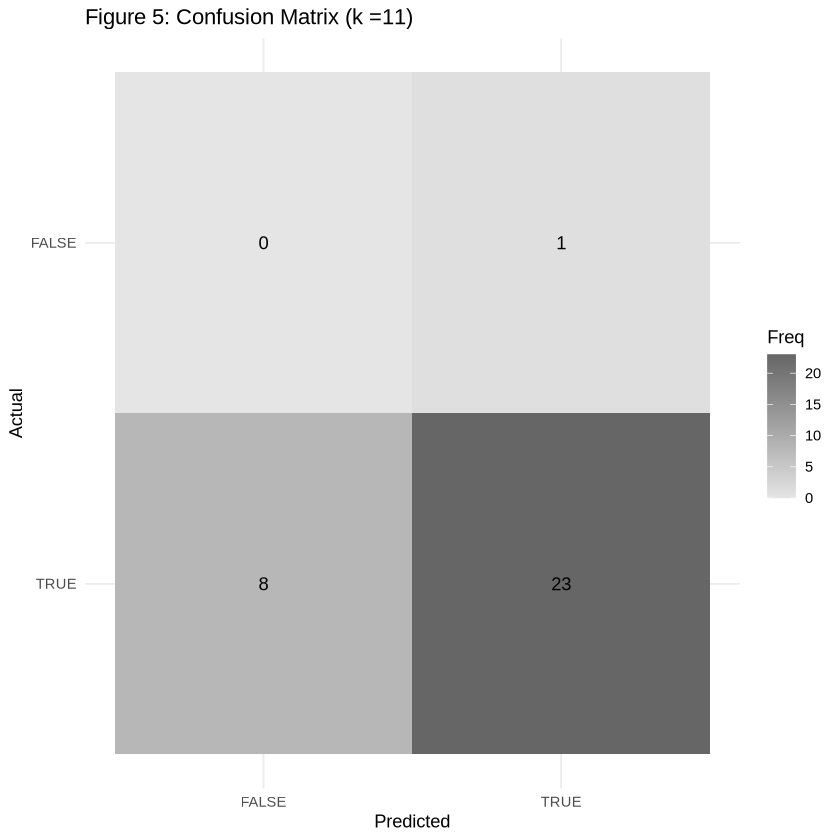

In [60]:
final_wf <- knn_tune_wf |>
  finalize_workflow(best_k)

last_fit_res <- final_wf |>
  last_fit(data_split)

last_fit_res |> collect_metrics() |> print()

preds <- last_fit_res |> collect_predictions()

conf_mat_obj <- preds |>
  conf_mat(truth = subscribe, estimate = .pred_class)

figure5 <- autoplot(conf_mat_obj, type = "heatmap") +
  labs(
    title = paste0("Figure 5: Confusion Matrix (k =11)"),
    x     = "Predicted",
    y     = "Actual") +
    theme_minimal()
figure5

accuracy(preds, truth = subscribe, estimate = .pred_class)

recall(preds, truth = subscribe, estimate = .pred_class, event_level = "second")

precision(preds, truth = subscribe, estimate = .pred_class, event_level = "second")

The k-nearest neighbors (k-NN) model was chosen because it's simple and works well for small datasets, especially when the goal is straightforward classification. The method assumes the data is scaled so distances between points are fair and meaningful. It also operates under the idea that players with similar patterns, such as session habits, will likely behave similarly when it comes to subscribing.
While k-NN is easy to use, there are some limitations. If the data is not appropriately scaled or includes noise, the model’s accuracy will decrease. It's also slower with large datasets. To address this, all predictors were scaled and centered during the preprocessing stage.

The data was split into training (70%) and testing (30%) to evaluate the model's performance. To tune the model, odd k-values from 1 to 21 were tested using 5-fold cross-validation. Figure 4 illustrates the variation in accuracy across these values. As k increased, accuracy fluctuated, but the k = 11 that achieved the highest accuracy was selected.

To assess the performance of the final model, a confusion matrix based on k = 11 was generated. Figure 5 presents this matrix as a heatmap, highlighting the model's accuracy in predicting each class. Most of the predictions are concentrated along the diagonal, which means the model correctly classified the majority of players. This suggests the k-NN model was reasonably effective at identifying subscribers and non-subscribers.

Beyond accuracy, recall and precision were also computed to gain a better understanding of performance. Accuracy indicates that the model was right overall. Recall measures the number of actual subscribers correctly identified, while precision suggests the proportion of predicted subscribers who were correctly identified. These metrics are beneficial when class distributions are imbalanced, as they help reveal strengths and weaknesses that accuracy alone might miss.


III. Discussion

The analysis revealed that players who played more frequently and for longer periods were more likely to subscribe to the newsletter. This outcome aligned with the expected hypothesis that more engaged players are typically more open to staying connected to a game through emails or updates.

These results are helpful for developers and marketers. If players who are highly engaged can be identified early on, subscription efforts can be more effectively focused on them, which could aid in retention strategies and targeted offers.

Although the model performed reasonably well, it was based on a limited number of features. Future work could examine other behavioral data, such as time of day, experience level, or age. Lastly, testing across different game genres or platforms could help generalize these findings.
